In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import gym
from tqdm import tqdm_notebook
import numpy as np
from collections import deque

In [2]:
#discount factor for future utilities
DISCOUNT_FACTOR = 0.99

#number of episodes to run
NUM_EPISODES = 1000

#max steps per episode
MAX_STEPS = 10000

#score agent needs for environment to be solved
SOLVED_SCORE = 450

#device to run model on 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
#Using a neural network to learn our policy parameters
class PolicyNetwork(nn.Module):
    
    #Takes in observations and outputs actions
    def __init__(self, observation_space, action_space):
        super(PolicyNetwork, self).__init__()
        self.input_layer = nn.Linear(observation_space, 128)
        self.output_layer = nn.Linear(128, action_space)
    
    #forward pass
    def forward(self, x):
        #input states
        x = self.input_layer(x)
        
        #relu activation
        x = F.relu(x)
        
        #actions
        actions = self.output_layer(x)
        
        #get softmax for a probability distribution
        action_probs = F.softmax(actions, dim=1)
        
        return action_probs

In [4]:
#Using a neural network to learn state value
class StateValueNetwork(nn.Module):
    
    #Takes in state
    def __init__(self, observation_space):
        super(StateValueNetwork, self).__init__()
        
        self.input_layer = nn.Linear(observation_space, 128)
        self.output_layer = nn.Linear(128, 1)
        
    def forward(self, x):
        #input layer
        x = self.input_layer(x)
        
        #activiation relu
        x = F.relu(x)
        
        #get state value
        state_value = self.output_layer(x)
        
        return state_value

In [5]:
def select_action(network, state):
    ''' Selects an action given current state
    Args:
    - network (Torch NN): network to process state
    - state (Array): Array of action space in an environment
    
    Return:
    - (int): action that is selected
    - (float): log probability of selecting that action given state and network
    '''
    
    #convert state to float tensor, add 1 dimension, allocate tensor on device
    state = torch.from_numpy(state).float().unsqueeze(0).to(DEVICE)
    
    #use network to predict action probabilities
    action_probs = network(state)
    state = state.detach()
    
    #sample an action using the probability distribution
    m = Categorical(action_probs)
    action = m.sample()
    
    #return action
    return action.item(), m.log_prob(action)

In [6]:
def process_rewards(rewards):
    ''' Converts our rewards history into cumulative discounted rewards
    Args:
    - rewards (Array): array of rewards 
    
    Returns:
    - G (Array): array of cumulative discounted rewards
    '''
    #Calculate Gt (cumulative discounted rewards)
    G = []
    
    #track cumulative reward
    total_r = 0
    
    #iterate rewards from Gt to G0
    for r in reversed(rewards):
        
        #Base case: G(T) = r(T)
        #Recursive: G(t) = r(t) + G(t+1)^DISCOUNT
        total_r = r + total_r ** DISCOUNT_FACTOR
        
        #add to front of G
        G.insert(0, total_r)
    
    #whitening rewards
#     G = torch.tensor(G).to(DEVICE)
#     G = (G - G.mean())/G.std()
    
    return G

In [7]:
def train_policy(deltas, log_probs, optimizer):
    ''' Update policy parameters
    Args:
    - deltas (Array): difference between predicted stateval and actual stateval (Gt)
    - log_probs (Array): trajectory of log probabilities of action taken
    - optimizer (Pytorch optimizer): optimizer to update policy network parameters
    '''
    
    #store updates
    policy_loss = []
    
    #calculate loss to be backpropagated
    for d, lp in zip(deltas, log_probs):
        #add negative sign since we are performing gradient ascent
        policy_loss.append(-d * lp)
    
    #Backpropagation
    optimizer.zero_grad()
    sum(policy_loss).backward()
    optimizer.step()
    

In [16]:
def train_value(G, state_vals, optimizer):
    ''' Update state-value network parameters
    Args:
    - G (Array): trajectory of cumulative discounted rewards 
    - state_vals (Array): trajectory of predicted state-value at each step
    - optimizer (Pytorch optimizer): optimizer to update state-value network parameters
    '''
    
    #calculate MSE loss
    val_loss = F.mse_loss(state_vals, G)
        
    #Backpropagate
    optimizer.zero_grad()
    val_loss.backward()
    optimizer.step()

In [17]:
#Make environment
env = gym.make('CartPole-v1')

#Init network
policy_network = PolicyNetwork(env.observation_space.shape[0], env.action_space.n).to(DEVICE)
stateval_network = StateValueNetwork(env.observation_space.shape[0]).to(DEVICE)


#Init optimizer
policy_optimizer = optim.Adam(policy_network.parameters(), lr=1e-2)
stateval_optimizer = optim.Adam(stateval_network.parameters(), lr=0.1)

In [18]:
#track scores
scores = []

#recent 100 scores
recent_scores = deque(maxlen=100)

#iterate through episodes
for episode in tqdm_notebook(range(NUM_EPISODES)):
    
    #reset environment, initiable variables
    state = env.reset()
    trajectory = []
    score = 0
    
    #generate episode
    for step in range(MAX_STEPS):
        #env.render()
        
        #select action
        action, lp = select_action(policy_network, state)
        
        #execute action
        new_state, reward, done, _ = env.step(action)
        
        #track episode score
        score += reward
        
        #store into trajectory
        trajectory.append([state, action, reward, lp])
        
        #end episode
        if done:
            break
        
        #move into new state
        state = new_state
    
    #append score
    scores.append(score)
    recent_scores.append(score)
    
    #check if agent finished training
    if len(recent_scores) == 100:
        average = sum(recent_scores)/len(recent_scores)
        if average >= SOLVED_SCORE:
            break
    
    
    #get items from trajectory
    states = [step[0] for step in trajectory]
    actions = [step[1] for step in trajectory]
    rewards = [step[2] for step in trajectory]
    lps = [step[3] for step in trajectory]
    
    #get discounted rewards
    G = process_rewards(rewards)
    G = torch.tensor(G).to(DEVICE)
    
    #calculate state values and train statevalue network
    state_vals = []
    for state in states:
        state = torch.from_numpy(state).float().unsqueeze(0).to(DEVICE)
        state_vals.append(stateval_network(state))
        
    state_vals = torch.stack(state_vals).squeeze()
    
    train_value(G, state_vals, stateval_optimizer)
        
    #calculate deltas and train policy network
    deltas = [gt - val for gt, val in zip(G, state_vals)]
    deltas = torch.tensor(deltas).to(DEVICE)
    
    train_policy(deltas, lps, policy_optimizer)
    

env.close()

#### Plotting training score:

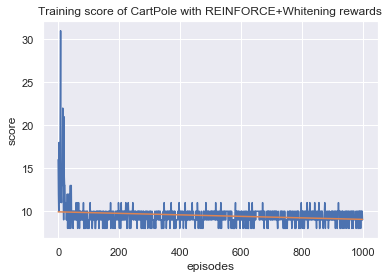

In [19]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np

sns.set()

plt.plot(scores)
plt.ylabel('score')
plt.xlabel('episodes')
plt.title('Training score of CartPole with REINFORCE+Whitening rewards')

reg = LinearRegression().fit(np.arange(len(scores)).reshape(-1, 1), np.array(scores).reshape(-1, 1))
y_pred = reg.predict(np.arange(len(scores)).reshape(-1, 1))
plt.plot(y_pred)
plt.show()

#### Random Policy:

In [ ]:
done = False
state = env.reset()
scores = []

for _ in range(10):
    state = env.reset()
    done = False
    score = 0
    while not done:
        env.render()
        action = env.action_space.sample()
        new_state, reward, done, info = env.step(action)
        score += reward
        state = new_state
    scores.append(score)
env.close()

#### Trying Policy:

In [15]:
done = False
state = env.reset()
scores = []

for _ in tqdm_notebook(range(50)):
    state = env.reset()
    done = False
    score = 0
    while not done:
        #env.render()
        action, lp = select_action(policy_network, state)
        new_state, reward, done, info = env.step(action)
        score += reward
        state = new_state
    scores.append(score)

In [16]:
np.array(scores).mean()

234.4